### Training a Regression Model Using TensorFlow for ET Stock Price Prediction

The objective is to find the "best fit" line or curve that models the relationship between volume and closing price. In linear regression, we assume a straight-line relationship: `closing_price ≈ a * volume + b`, where `a` is the slope and `b` is the intercept. This is simple but may not capture complex patterns, as stock prices and volume often have a non-linear, weak, or indirect relationship (e.g., higher volume might correlate with price volatility but not directly predict the exact closing price). For non-linear regression, we'll use a deep neural network (DNN) to learn more intricate mappings, potentially improving fit by capturing non-linearities like thresholds or interactions.

Sources:
- https://github.com/adidror005/youtube-videos/blob/main/old_videos/hello_ib_async_actual.ipynb
- https://github.com/erdewit/ib_insync
- https://ib-insync.readthedocs.io/api.html
- https://www.interactivebrokers.com/campus/ibkr-api-page/twsapi-doc/#tws-config-api

In [53]:
from ib_async import *

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

util.startLoop()
ib = IB()
ib.connect('10.0.0.42', 4010, clientId=1)

2.15.1


<IB connected to 10.0.0.42:4010 clientId=1>

In [79]:
# Define the contract for the stock you want to trade
contract = Contract(symbol='ET',secType='STK',exchange='SMART',currency='USD')
ib.qualifyContracts(contract)
contract

Contract(secType='STK', conId=37830920, symbol='ET', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='ET', tradingClass='ET')

In [80]:
# Convert the contract details to a DataFrame for better visualization
ET_Contract = Stock('ET', 'SMART', 'USD')
ET_CDS = ib.reqContractDetails(ET_Contract)

In [81]:
# Convert the contract details to a DataFrame
df_ET_contract_details = util.df(ET_CDS)
df_ET_contract_details.head()

,contract,marketName,minTick,orderTypes,validExchanges,priceMagnifier,underConId,longName,contractMonth,industry,...,callable,putable,coupon,convertible,maturity,issueDate,nextOptionDate,nextOptionType,nextOptionPartial,notes
0,"Contract(secType='STK', conId=37830920, symbol...",ET,0.01,"ACTIVETIM,AD,ADDONT,ADJUST,ALERT,ALGO,ALLOC,AO...","SMART,AMEX,NYSE,CBOE,PHLX,ISE,CHX,ARCA,ISLAND,...",1,0,ENERGY TRANSFER LP,,Energy,...,False,False,0,False,,,,,False,


In [82]:
# Fetch Historical Data from IBKR

ET_Stock = ib.reqHistoricalData(
    contract,
    endDateTime='',
    durationStr='5 Y',
    barSizeSetting='4 hours',
    whatToShow='TRADES',
    useRTH=True,
    formatDate=1
)

df = util.df(ET_Stock)
df.head()

,date,open,high,low,close,volume,average,barCount
0,2021-02-12 09:30:00-05:00,6.78,6.93,6.74,6.79,59726.19,6.861,10144
1,2021-02-12 11:00:00-05:00,6.79,6.88,6.78,6.83,58526.35,6.831,12352
2,2021-02-12 15:00:00-05:00,6.82,6.84,6.80,6.82,15228.78,6.822,2932
3,2021-02-16 09:30:00-05:00,6.95,7.00,6.86,6.94,62014.03,6.946,9788
4,2021-02-16 11:00:00-05:00,6.94,6.98,6.93,6.97,64672.68,6.961,11885


In [83]:
# 3. Clean the Data and Drop Rows with Errors

# Check for NaNs
print(df.isnull().sum())

# Drop rows with NaNs or errors (e.g., volume <= 0)
df = df.dropna()
df = df[df['volume'] > 0]

# Select relevant columns
df = df[['date', 'open', 'high', 'low', 'close', 'volume']]
df = df.sort_values('date')  # Ensure chronological order
print(df.shape)

date        0
open        0
high        0
low         0
close       0
volume      0
average     0
barCount    0
dtype: int64
(2928, 6)


In [84]:
# Drop the rows to keep thing simple

dataset = df.drop(['date'], axis=1)
dataset.head()

,open,high,low,close,volume
0,6.78,6.93,6.74,6.79,59726.19
1,6.79,6.88,6.78,6.83,58526.35
2,6.82,6.84,6.80,6.82,15228.78
3,6.95,7.00,6.86,6.94,62014.03
4,6.94,6.98,6.93,6.97,64672.68


4. Specify the Variables and Explain the Relationship

- `Features (Inputs):` Volume (primary, one-feature model); Open, High, Low, Volume (all-features model).
- `Label (Output):` Close.
- `Relationship:` We aim to model `close = f(volume)` or `close = f(open, high, low, volume)`. Volume often weakly correlates with price (e.g., Pearson correlation ~0.1-0.3), as high volume can signal buying/selling pressure but doesn't linearly dictate close. Linear assumes direct proportionality; non-linear allows curves/polynomials.

In [85]:
# Compute correlation
print(df.corr()['close'])  # Focus on 'volume' vs 'close'

date      0.939069
open      0.999255
high      0.999632
low       0.999614
close     1.000000
volume   -0.206597
Name: close, dtype: float64


In [118]:
# 5. Train Dataset, Test Dataset

train_size = int(len(df) * 0.8)
train_dataset = df.iloc[:train_size]
test_dataset = df.iloc[train_size:]
print(train_dataset.shape, test_dataset.shape)

(2342, 6) (586, 6)


In [119]:
# 6. Split Features from Labels, and Use Normalization

from sklearn.preprocessing import MinMaxScaler

# One-feature: volume only
train_features_one = train_dataset[['volume']].copy()
test_features_one = test_dataset[['volume']].copy()

# All-features
train_features_all = train_dataset[['open', 'high', 'low', 'volume']].copy()
test_features_all = test_dataset[['open', 'high', 'low', 'volume']].copy()

train_labels = train_dataset['close'].copy()
test_labels = test_dataset['close'].copy()

# Normalize
scaler_features = MinMaxScaler()
scaler_labels = MinMaxScaler()

train_features_one = scaler_features.fit_transform(train_features_one)
test_features_one = scaler_features.transform(test_features_one)

train_features_all = scaler_features.fit_transform(train_features_all)
test_features_all = scaler_features.transform(test_features_all)

train_labels = scaler_labels.fit_transform(train_labels.values.reshape(-1, 1))
test_labels = scaler_labels.transform(test_labels.values.reshape(-1, 1))

In [120]:
# 7. Define linearModel and nonLinearModel

# Linear models
def build_linear_model(input_shape):
    model = keras.Sequential([layers.Dense(1, input_shape=(input_shape,))])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

linOneFeatureModel = build_linear_model(1)  # Input: volume
linAllFeatureModel = build_linear_model(4)  # Input: open, high, low, volume

# Non-linear model (DNN)
def build_nonlinear_model(input_shape):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Output: close
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

nonLinearModel = build_nonlinear_model(4)  # Using all features for complexity

In [121]:
# Summary of models
print("Linear Model (One Feature):")
linOneFeatureModel.summary()

print("\nLinear Model (All Features):")
linAllFeatureModel.summary()

Linear Model (One Feature):
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Linear Model (All Features):
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 1)                 5         
                                                                 
Total params: 5 (20.00 Byte)
Trainable params: 5 (20.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [122]:
%%time
# 8. Linear Regression with One Feature
history_lin_one = linOneFeatureModel.fit(
    train_features_one, train_labels,
    validation_data=(test_features_one, test_labels),
    epochs=100,
    batch_size=32,
    verbose=0
)

CPU times: user 27.8 s, sys: 2.31 s, total: 30.1 s
Wall time: 17.4 s


In [123]:
hist = pd.DataFrame(history_lin_one.history)
hist['epoch'] = history_lin_one.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
95,0.041719,0.158168,0.112093,0.327153,95
96,0.041711,0.157332,0.111503,0.326266,96
97,0.041706,0.157581,0.111387,0.326072,97
98,0.041716,0.157557,0.111151,0.325719,98
99,0.041709,0.157576,0.113798,0.329752,99


In [124]:
# Function to plot training and validation loss

def plot_loss(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid()
    plt.show()

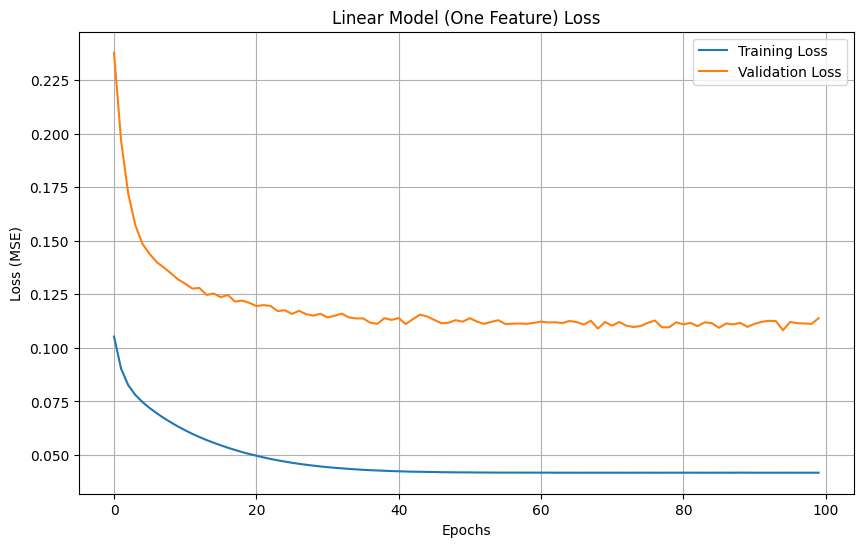

In [125]:
plot_loss(history_lin_one, "Linear Model (One Feature) Loss")

In [126]:
%%time
# 9. Linear Regression with All Features
history_lin_all = linAllFeatureModel.fit(
    train_features_all, train_labels,
    validation_data=(test_features_all, test_labels),
    epochs=100,
    batch_size=32,
    verbose=0
)

CPU times: user 27.2 s, sys: 2.32 s, total: 29.6 s
Wall time: 17 s


In [127]:
hist_all = pd.DataFrame(history_lin_all.history)
hist_all['epoch'] = history_lin_all.epoch
hist_all.tail()

,loss,mae,val_loss,val_mae,epoch
95,0.000038,0.004530,0.000063,0.005595,95
96,0.000038,0.004493,0.000063,0.005580,96
97,0.000037,0.004447,0.000064,0.005586,97
98,0.000036,0.004422,0.000064,0.005584,98
99,0.000036,0.004428,0.000065,0.005495,99


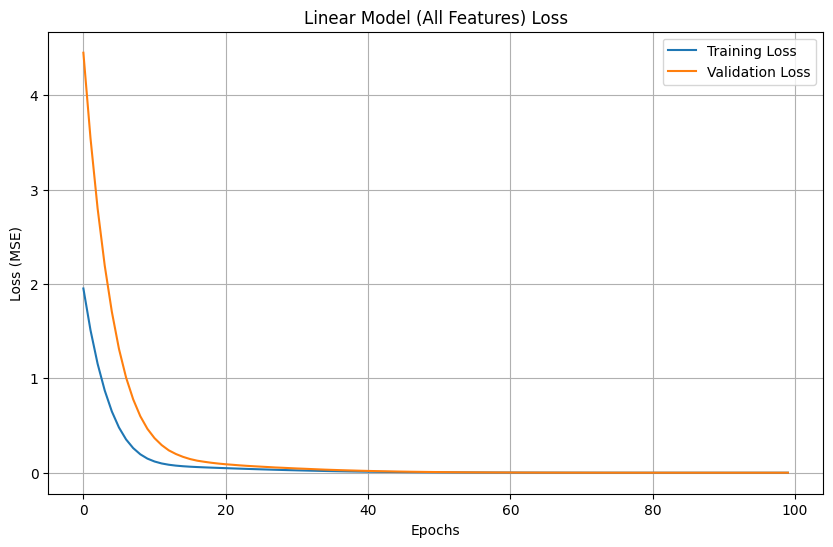

In [128]:
plot_loss(history_lin_all, "Linear Model (All Features) Loss")

In [133]:
# 10. Test the Results, Plot the History, and the Data
test_results = {}

test_results['Linear (One Feature)'] = linOneFeatureModel.evaluate(test_features_one, test_labels, verbose=0)
test_results['Linear (All Features)'] = linAllFeatureModel.evaluate(test_features_all, test_labels, verbose=0)

print("Test Results:")
for model_name, result in test_results.items():
    print(f"{model_name} - Loss (MSE): {result[0]:.4f}, MAE: {result[1]:.4f}")

Test Results:
Linear (One Feature) - Loss (MSE): 0.1138, MAE: 0.3298
Linear (All Features) - Loss (MSE): 0.0001, MAE: 0.0055


In [130]:
pd.DataFrame(test_results, index=['Loss (MSE)', 'MAE']).T

,Loss (MSE),MAE
Linear (One Feature),0.113798,0.329752
Linear (All Features),0.000065,0.005495


19/19 [==============================] - 0s 1ms/step


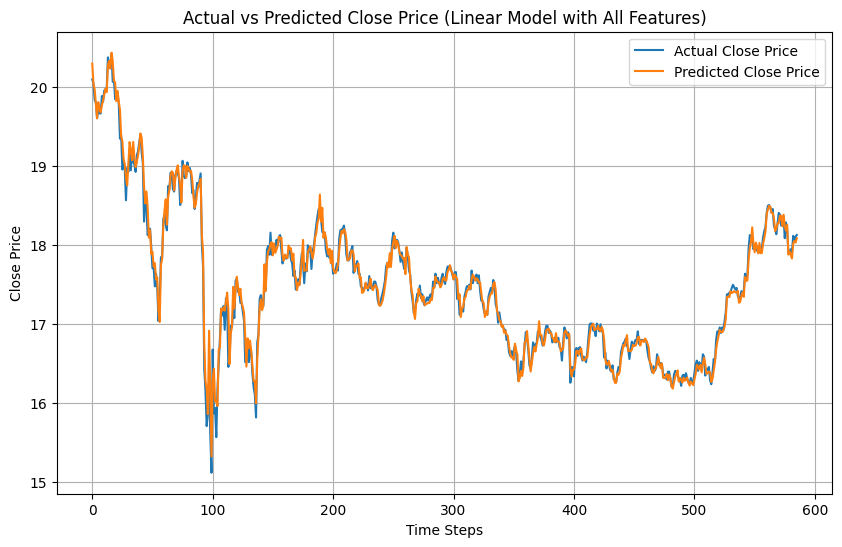

In [132]:
# Plot the actual vs predicted for the best model (Linear with All Features)
predictions = linAllFeatureModel.predict(test_features_all)
predictions = scaler_labels.inverse_transform(predictions)
actual = scaler_labels.inverse_transform(test_labels)
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Close Price')
plt.plot(predictions, label='Predicted Close Price')
plt.title("Actual vs Predicted Close Price (Linear Model with All Features)")
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

In [110]:
# 11. Predict on test All Features
x = tf.linspace(0, 1, 100)
y = linAllFeatureModel.predict(test_features_all)

19/19 [==============================] - 0s 1ms/step


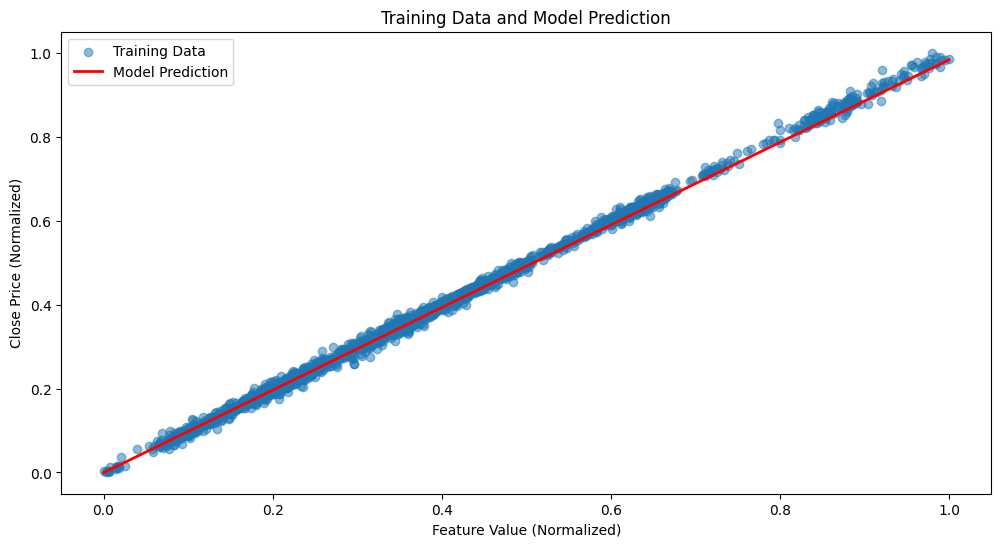

In [115]:
def plot_training_data(x: np.ndarray, y: np.ndarray) -> None:
    plt.figure(figsize=(12, 6))
    plt.scatter(train_features_all[:, 0], train_labels, label='Training Data', alpha=0.5)
    # Reshape x to be 2D with 3 features (repeat first feature for all 3 input dimensions)
    x_reshaped = np.column_stack([x, x, x])
    y_pred = linAllFeatureModel.predict(x_reshaped, verbose=0)
    plt.plot(x, y_pred, color='red', linewidth=2, label='Model Prediction')
    plt.title("Training Data and Model Prediction")
    plt.xlabel('Feature Value (Normalized)')
    plt.ylabel('Close Price (Normalized)')
    plt.legend()
    plt.show()

plot_training_data(x.numpy(), y)

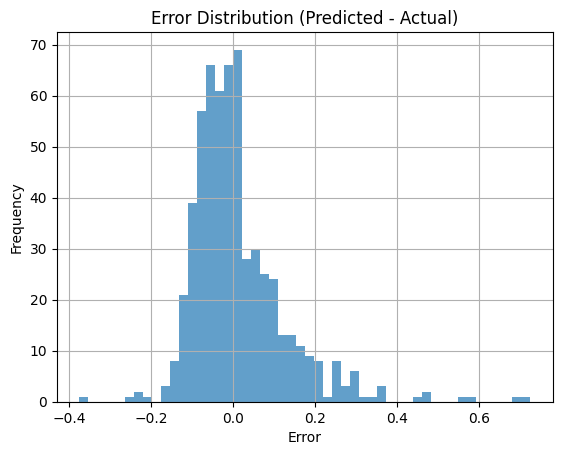

In [135]:
# 12. Error Distribution

error = predictions - actual
plt.hist(error, bins=50, alpha=0.7)
plt.title("Error Distribution (Predicted - Actual)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [136]:
# Save Load Model

linAllFeatureModel.save('linear_all_features_model')
reloaded_model = keras.models.load_model('linear_all_features_model')

test_results_reloaded = reloaded_model.evaluate(test_features_all, test_labels, verbose=0)

pd.DataFrame({'Original Model': test_results['Linear (All Features)'], 'Reloaded Model': test_results_reloaded}, index=['Loss (MSE)', 'MAE']).T

INFO:tensorflow:Assets written to: linear_all_features_model/assets


INFO:tensorflow:Assets written to: linear_all_features_model/assets


,Loss (MSE),MAE
Original Model,0.000065,0.005495
Reloaded Model,0.000065,0.005495
